In [1]:
# ==============================================================
#                   Entire File Made by Oscar Boman
# ==============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
from bioNet import BioNet, BioNetLoss
from torchvision.datasets import LFWPairs


import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Example

In [21]:


transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="../Pre-processing/Curated_Dataset", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(dataset.classes)

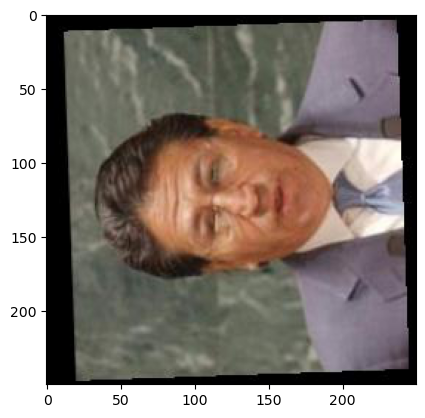

In [22]:
plt.imshow(dataset[0][0].T)

In [23]:

vgg16 = models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001) 


Epoch [1/200], Loss: 4.1272
Validation Loss: 4.1272, Accuracy: 0.0134
Epoch [2/200], Loss: 4.1213
Validation Loss: 4.1213, Accuracy: 0.0134
Epoch [3/200], Loss: 4.1103
Validation Loss: 4.1073, Accuracy: 0.0209
Epoch [4/200], Loss: 4.0857
Validation Loss: 4.0574, Accuracy: 0.0254
Epoch [5/200], Loss: 3.9550
Validation Loss: 3.7999, Accuracy: 0.0582
Epoch [6/200], Loss: 3.5979
Validation Loss: 3.4683, Accuracy: 0.1090
Epoch [7/200], Loss: 3.2389
Validation Loss: 3.1624, Accuracy: 0.1940
Epoch [8/200], Loss: 2.7413
Validation Loss: 2.8365, Accuracy: 0.2701
Epoch [9/200], Loss: 2.1117
Validation Loss: 2.6146, Accuracy: 0.3030
Epoch [10/200], Loss: 1.4182
Validation Loss: 2.2198, Accuracy: 0.4045
Epoch [11/200], Loss: 0.7341
Validation Loss: 2.2781, Accuracy: 0.4373
Epoch [12/200], Loss: 0.4142
Validation Loss: 2.6121, Accuracy: 0.4701
Epoch [13/200], Loss: 0.2814
Validation Loss: 2.5650, Accuracy: 0.5104
Epoch [14/200], Loss: 0.1663
Validation Loss: 2.4241, Accuracy: 0.4761
Epoch [15/200],

<function matplotlib.pyplot.show(close=None, block=None)>

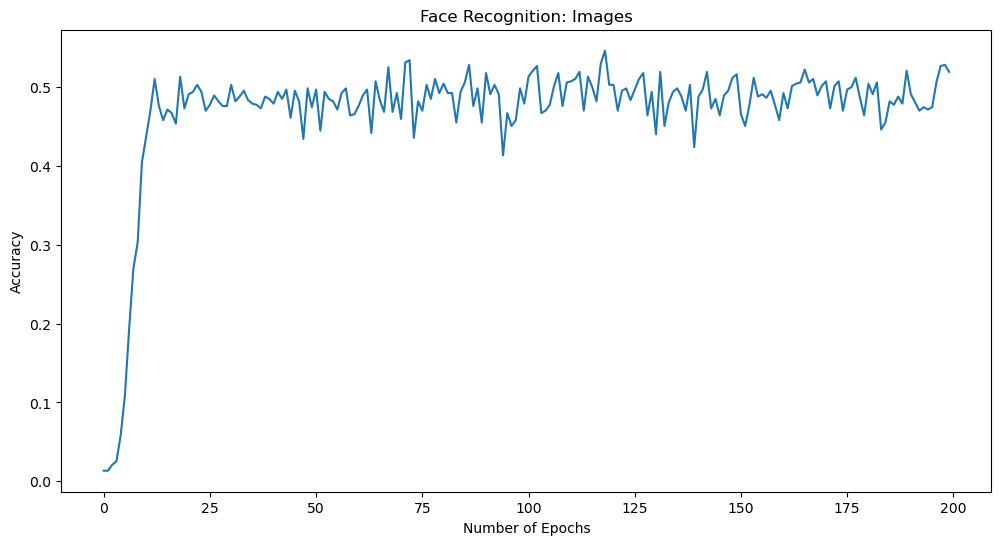

In [24]:
num_epochs = 200
val_accuracy_list = []
for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = vgg16(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        
        loss.backward()  # Backward pass (calculate gradients)
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Validate the model
    vgg16.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    
    val_loss /= len(val_loader.dataset)
    accuracy = correct / total
    val_accuracy_list.append(accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(np.arange(num_epochs), val_accuracy_list)
plt.title('Face Recognition: Images')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show


#### MetricNet 

In [ ]:
from bioNet import VGG16_MetricNet


def train_vgg16_model(data, n_epochs=200, batch_size=500, learning_rate=0.001):
    """
    Trains a VGG16-like model on the provided data.

    Parameters:
        data (pd.DataFrame): Input data with features and 'label' column.
        model_class (class): Class for the model to instantiate (e.g., VGG16_MetricNet).
        n_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model: Trained model.
        val_accuracy_list (list): List of validation accuracies per epoch.
    """
    X = data.drop(columns=['label']).to_numpy()
    y = data['label'].to_numpy()

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    input_size = X_train.shape[1]
    num_classes = len(label_encoder.classes_)

    model = VGG16_MetricNet(input_shape=input_size, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    val_accuracy_list = []

    for epoch in range(n_epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            Xbatch = X_train_tensor[i:i + batch_size]
            ybatch = y_train_tensor[i:i + batch_size]

            y_pred = model(Xbatch)
            loss = criterion(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            _, val_pred = torch.max(val_outputs, 1)
            val_accuracy = accuracy_score(y_test_tensor.numpy(), val_pred.numpy())
            

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")
            val_accuracy_list.append(val_accuracy)

    return model, val_accuracy_list


directory = "../Pre-processing/dataset/anchor_points_dataset/face_recognition/"
plt.figure(figsize=(12, 6))
plt.title('Face Recognition: Feature Vectors')
epochs = 500
for file in os.listdir(directory):
    path = os.path.join(directory, file)
    df = pd.read_csv(path)
    _, acc = train_vgg16_model(df, n_epochs=epochs)
    plt.plot(np.arange(epochs, step=10), acc, label=file)

plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()


Epoch [10/500], Loss: 4.0735, Val Accuracy: 2.08%
Epoch [20/500], Loss: 3.9489, Val Accuracy: 2.95%
Epoch [30/500], Loss: 3.8703, Val Accuracy: 3.30%
Epoch [40/500], Loss: 3.8355, Val Accuracy: 3.65%
Epoch [50/500], Loss: 3.7928, Val Accuracy: 3.82%
Epoch [60/500], Loss: 3.7663, Val Accuracy: 3.65%
Epoch [70/500], Loss: 3.7488, Val Accuracy: 3.12%
Epoch [80/500], Loss: 3.7234, Val Accuracy: 3.82%
Epoch [90/500], Loss: 3.7148, Val Accuracy: 3.82%
Epoch [100/500], Loss: 3.7034, Val Accuracy: 3.82%
Epoch [110/500], Loss: 3.6877, Val Accuracy: 3.47%
Epoch [120/500], Loss: 3.6645, Val Accuracy: 3.82%
Epoch [130/500], Loss: 3.6363, Val Accuracy: 3.65%
Epoch [140/500], Loss: 3.6508, Val Accuracy: 3.47%
Epoch [150/500], Loss: 3.5891, Val Accuracy: 4.34%
Epoch [160/500], Loss: 3.5765, Val Accuracy: 3.82%
Epoch [170/500], Loss: 3.5851, Val Accuracy: 3.82%
Epoch [180/500], Loss: 3.5343, Val Accuracy: 4.69%
Epoch [190/500], Loss: 3.5012, Val Accuracy: 3.99%
Epoch [200/500], Loss: 3.4799, Val Accur

## Face Validation

In [ ]:


mu_m = torch.tensor([0]).to(device) # Matching
mu_n = torch.tensor([40]).to(device) # Non-matching

sigma = torch.tensor([[1.0]]).to(device)
p = torch.tensor([1]).to(device)

batch_size = 16
learning_rate = 1e-3

model = BioNet().to(device=device)
criterion = BioNetLoss(p, mu_n, mu_m, sigma)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

transform = transforms.Compose([
    transforms.Resize((299, 299)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor()])

lfw_pairs_dataset_train = LFWPairs(
    root="./data/train",  
    split="train",  
    transform=transform,
    download=True
)
lfw_pairs_dataset_test = LFWPairs(
    root="./data/test",  
    split="test",  
    transform=transform,
    download=True
)

print(len(lfw_pairs_dataset_train))

train_loader = DataLoader(lfw_pairs_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(lfw_pairs_dataset_test, batch_size=batch_size, shuffle=True)

epochs = 200
val_accuracy_list = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    all_predictions = []
    all_labels = []

    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        
        # Forward pass
        distances = model(img1, img2 )
        # Compute loss
        loss = criterion(distances, labels.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        predictions = (distances < criterion.threshold()).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    all_predictions = [int(x) for sublist in all_predictions for x in sublist]
    accuracy_train = accuracy_score(all_labels, all_predictions)


    all_predictions = []
    all_labels = []
    all_distance = []
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            distances = model(img1, img2)
            
            predictions = (distances < criterion.threshold()).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy

    all_predictions = [int(x) for sublist in all_predictions for x in sublist]


    accuracy_test = accuracy_score(all_labels, all_predictions)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")
    val_accuracy_list.append(accuracy_test)


plt.figure(figsize=(12, 6))
plt.plot(np.arange(200), val_accuracy_list)
plt.title('Face Validation: Images')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show

Files already downloaded and verified
Files already downloaded and verified
2200
Epoch 1/200, Loss: 435.8661, Train Accuracy: 0.5041, Test Accuracy: 0.5220
Epoch 2/200, Loss: 398.1369, Train Accuracy: 0.5268, Test Accuracy: 0.5240
Epoch 3/200, Loss: 397.2829, Train Accuracy: 0.5341, Test Accuracy: 0.5320
Epoch 4/200, Loss: 393.9313, Train Accuracy: 0.5441, Test Accuracy: 0.5350
Epoch 5/200, Loss: 395.6057, Train Accuracy: 0.5468, Test Accuracy: 0.5060
Epoch 6/200, Loss: 392.9611, Train Accuracy: 0.5536, Test Accuracy: 0.5280
Epoch 7/200, Loss: 389.1450, Train Accuracy: 0.5718, Test Accuracy: 0.5240
Epoch 8/200, Loss: 389.2670, Train Accuracy: 0.5609, Test Accuracy: 0.5350
Epoch 9/200, Loss: 380.5307, Train Accuracy: 0.5964, Test Accuracy: 0.5470
Epoch 10/200, Loss: 375.7461, Train Accuracy: 0.6164, Test Accuracy: 0.5770
Epoch 11/200, Loss: 356.0917, Train Accuracy: 0.6368, Test Accuracy: 0.6120
Epoch 12/200, Loss: 344.7757, Train Accuracy: 0.6482, Test Accuracy: 0.5890
Epoch 13/200, Lo

NameError: name 'num_epochs' is not defined

<Figure size 1200x600 with 0 Axes>

Epoch 10/500, Loss: 398.9675, Test Accuracy: 0.5288
Epoch 20/500, Loss: 398.3076, Test Accuracy: 0.5136
Epoch 30/500, Loss: 397.5611, Test Accuracy: 0.4924
Epoch 40/500, Loss: 397.1477, Test Accuracy: 0.5015
Epoch 50/500, Loss: 396.7049, Test Accuracy: 0.5030
Epoch 60/500, Loss: 396.3860, Test Accuracy: 0.5106
Epoch 70/500, Loss: 396.1309, Test Accuracy: 0.5091
Epoch 80/500, Loss: 395.8999, Test Accuracy: 0.5121
Epoch 90/500, Loss: 395.7054, Test Accuracy: 0.5136
Epoch 100/500, Loss: 395.5299, Test Accuracy: 0.5091
Epoch 110/500, Loss: 395.4004, Test Accuracy: 0.5136
Epoch 120/500, Loss: 395.2278, Test Accuracy: 0.5121
Epoch 130/500, Loss: 395.1103, Test Accuracy: 0.5091
Epoch 140/500, Loss: 394.9961, Test Accuracy: 0.5091
Epoch 150/500, Loss: 394.8797, Test Accuracy: 0.5076
Epoch 160/500, Loss: 394.8515, Test Accuracy: 0.5167
Epoch 170/500, Loss: 394.6817, Test Accuracy: 0.5106
Epoch 180/500, Loss: 394.7178, Test Accuracy: 0.5152
Epoch 190/500, Loss: 394.4914, Test Accuracy: 0.5106
Ep

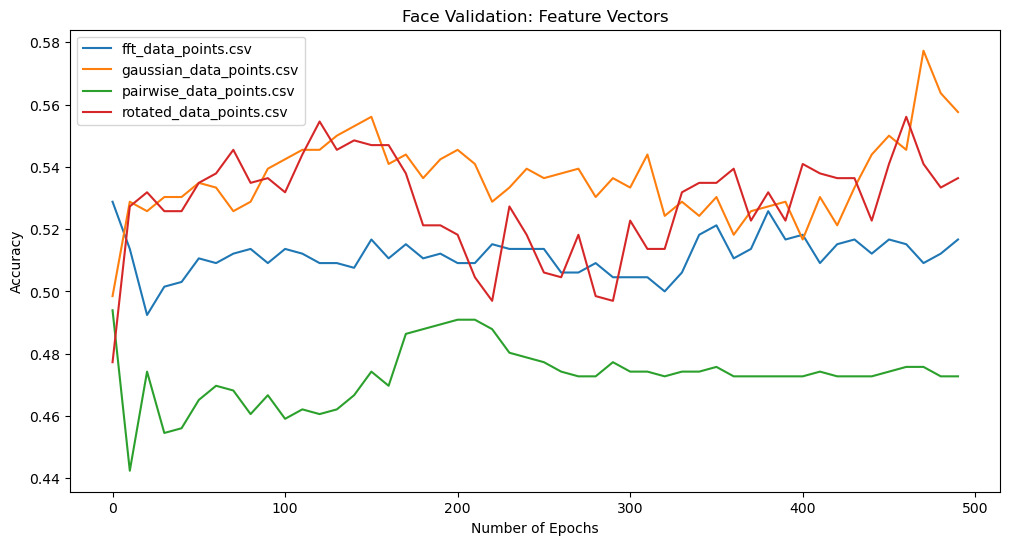

In [7]:

from bioNet import VGG16_MetricNet

def train_metricnet_model(data, n_epochs=10000, batch_size=16, learning_rate=1e-3):
    """
    Trains a MetricNet model on the provided data.

    Parameters:
        data (pd.DataFrame): Input data with features and 'label' column.
        n_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model: Trained model.
        val_accuracy_list (list): List of validation accuracies per epoch.
    """
    X = data.drop(columns=['label']).to_numpy()
    y = data['label'].to_numpy()

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    input_size = X_train.shape[1]

    mu_m = torch.tensor([0]).to(device)  # Matching
    mu_n = torch.tensor([40]).to(device)  # Non-matching
    sigma = torch.tensor([[1.0]]).to(device)
    p = torch.tensor([1]).to(device)

    model = VGG16_MetricNet(input_size).to(device)
    criterion = BioNetLoss(p, mu_n, mu_m, sigma)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    val_accuracy_list = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            Xbatch = X_train_tensor[i:i + batch_size]
            ybatch = y_train_tensor[i:i + batch_size]

            y_pred = model(Xbatch)
            loss = criterion(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                Xbatch = X_test_tensor[i:i + batch_size]
                labels = y_test_tensor[i:i + batch_size]
                distances = model(Xbatch)

                predictions = (distances < criterion.threshold()).float()

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        all_predictions = [int(x) for sublist in all_predictions for x in sublist]
        accuracy_test = accuracy_score(all_labels, all_predictions)
        

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss / (len(X_train) / batch_size):.4f}, Test Accuracy: {accuracy_test:.4f}")
            val_accuracy_list.append(accuracy_test)

    return model, val_accuracy_list

directory = "../Pre-processing/dataset/anchor_points_dataset/face_validation/"
plt.figure(figsize=(12, 6))
plt.title('Face Validation: Feature Vectors')
epochs = 500
for file in os.listdir(directory):
    path = os.path.join(directory, file)
    df = pd.read_csv(path)
    _, acc = train_metricnet_model(df, n_epochs=epochs)
    plt.plot(np.arange(epochs, step=10), acc, label=file)

plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()